##Модели DENSE NN, CNN, LSTM - 2

/tmp/ipython-input-3-3074422730.py:16: DtypeWarning: Columns (23,24,37,42,43,52,54,55,56,60,61,62,65,67) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('merged_data.csv')
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - loss: 14.4770 - mae: 2.7384 - val_loss: 13.5017 - val_mae: 2.8349
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - loss: 5.3529 - mae: 1.2858 - val_loss: 14.4023 - val_mae: 2.8338
Epoch 3/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - loss: 4.9619 - mae: 1.2575 - val_loss: 5.0354 - val_mae: 1.3832
Epoch 4/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 41s 127ms/step - loss: 4.6637 - mae: 1.2305 - val_loss: 4.0656 - val_mae: 1.1376
Epoch 5/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 25s 127ms/step - loss: 4.3268 - mae: 1.2091 - val_loss: 3.7755 - val_mae: 1.1032
Epoch 6/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 41s 128ms/step - loss: 3.9062 - mae: 1.1544 - val_loss: 3.5792 - val_mae: 1.0959
Epoch 7/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - loss: 3.7697 - mae: 1.1831 - val_loss: 3.3586 - val_mae: 1.1027
Epoch 8/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 40s 127ms/step - loss: 3.4868 - mae: 1.1566 - val_loss: 3.1623 - val_mae: 1.1088
Epoch 9/100
195/195 ━

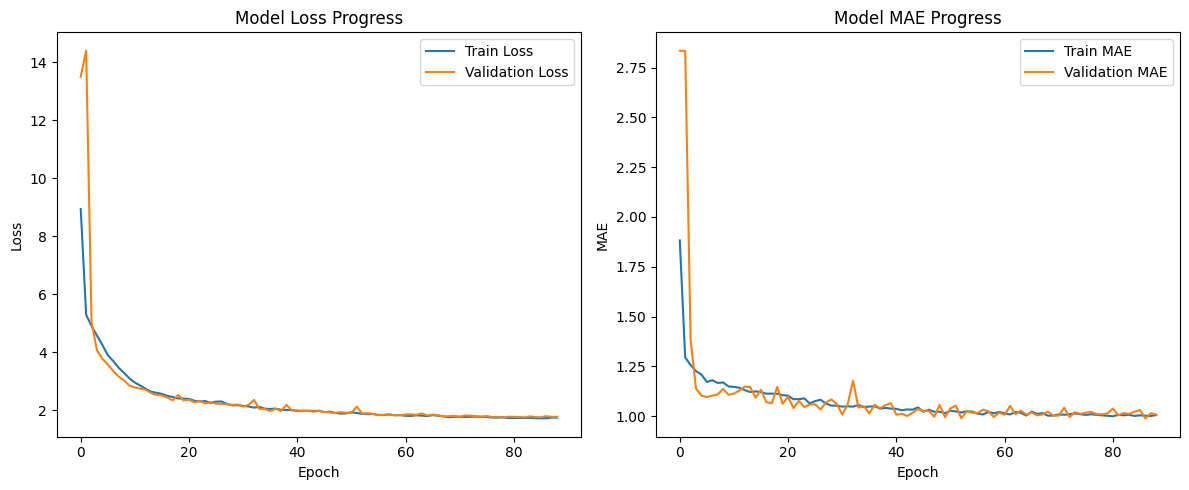

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np


df = pd.read_csv('merged_data.csv')
y = df['stars']
drop_cols = ['address', 'business_id', 'name', 'postal_code', 'review_id',
             'user_id', 'date', 'date_dt', 'date_only', 'text']
X = df.drop(drop_cols + ['stars'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

sequence_length = X_train_processed.shape[1]
X_train_cnn = X_train_processed.reshape(-1, sequence_length, 1).astype('float32')
X_test_cnn = X_test_processed.reshape(-1, sequence_length, 1).astype('float32')
y_train_nn = y_train.values.astype('float32')
y_test_nn = y_test.values.astype('float32')


def build_optimized_cnn(input_shape):
    model = Sequential([
        Conv1D(128, 5, activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.4),

        Conv1D(64, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.3),

        Flatten(),

        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(64, activation='relu', kernel_regularizer=l2(0.005)),
        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae']
    )
    return model


optimized_cnn = build_optimized_cnn((sequence_length, 1))
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = optimized_cnn.fit(
    X_train_cnn, y_train_nn,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


cnn_pred = optimized_cnn.predict(X_test_cnn).flatten()
cnn_mse = mean_squared_error(y_test_nn, cnn_pred)
cnn_rmse = np.sqrt(cnn_mse)
cnn_r2 = r2_score(y_test_nn, cnn_pred)

print("\nOptimized CNN Results:")
print(f"MSE: {cnn_mse:.4f}")
print(f"RMSE: {cnn_rmse:.4f}")
print(f"R2: {cnn_r2:.4f}")


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE Progress')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


optimized_cnn.save('optimized_cnn_model.h5')

/tmp/ipython-input-1-3618245495.py:17: DtypeWarning: Columns (23,24,37,42,43,52,54,55,56,60,61,62,65,67) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('merged_data.csv')


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.7215 - mae: 1.5373 - val_loss: 1.7591 - val_mae: 1.1245
Epoch 2/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9070 - mae: 1.1513 - val_loss: 1.7457 - val_mae: 1.1188
Epoch 3/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8738 - mae: 1.1369 - val_loss: 2.3101 - val_mae: 1.3059
Epoch 4/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8473 - mae: 1.1285 - val_loss: 1.8664 - val_mae: 1.1565
Epoch 5/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7784 - mae: 1.1022 - val_loss: 2.1178 - val_mae: 1.2450
Epoch 6/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.7466 - mae: 1.1020 - val_loss: 2.0023 - val_mae: 1.2109
Epoch 7/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7477 - mae: 1.1019 - val_loss: 1.7145 - val_mae: 1.1152
Epoch 8/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7332 - mae: 1.0972 - val_loss: 1.6778 - val_mae: 1.0770
Epoch 9/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7280 

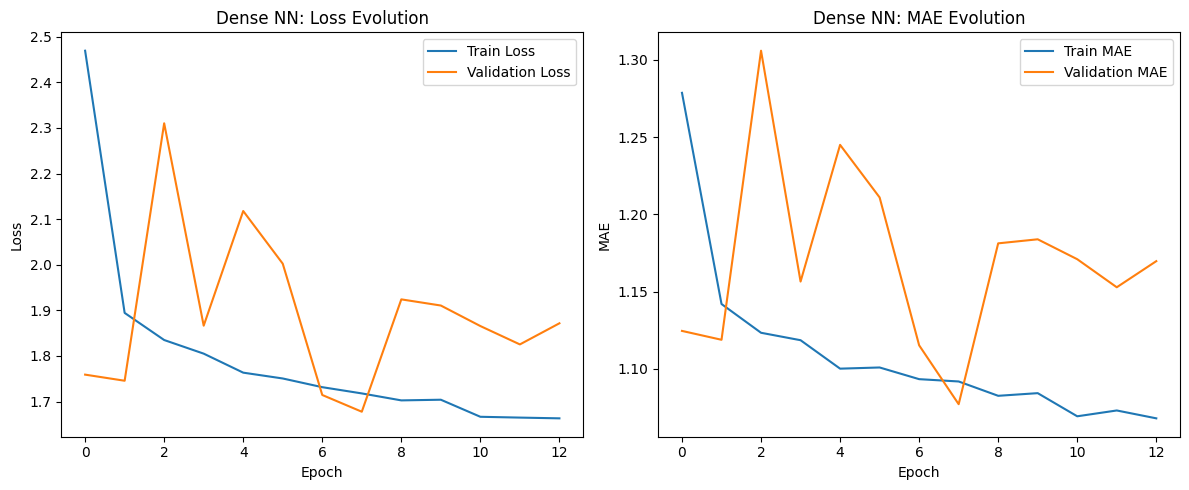

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv('merged_data.csv')
y = df['stars']
drop_cols = ['address', 'business_id', 'name', 'postal_code', 'review_id',
             'user_id', 'date', 'date_dt', 'date_only', 'text']
X = df.drop(drop_cols + ['stars'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

if hasattr(X_train_processed, 'toarray'):
    X_train_processed = X_train_processed.toarray()
    X_test_processed = X_test_processed.toarray()

X_train_nn = X_train_processed.astype('float32')
X_test_nn = X_test_processed.astype('float32')
y_train_nn = y_train.values.astype('float32')
y_test_nn = y_test.values.astype('float32')

def build_dense_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

dense_model = build_dense_model(X_train_nn.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history_dense = dense_model.fit(
    X_train_nn, y_train_nn,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


dense_pred = dense_model.predict(X_test_nn).flatten()
dense_mse = mean_squared_error(y_test_nn, dense_pred)
dense_r2 = r2_score(y_test_nn, dense_pred)
print(f"Dense NN - MSE: {dense_mse:.4f}, R2: {dense_r2:.4f}")


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dense.history['loss'], label='Train Loss')
plt.plot(history_dense.history['val_loss'], label='Validation Loss')
plt.title('Dense NN: Loss Evolution')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history_dense.history['mae'], label='Train MAE')
plt.plot(history_dense.history['val_mae'], label='Validation MAE')
plt.title('Dense NN: MAE Evolution')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

/tmp/ipython-input-5-1226428367.py:19: DtypeWarning: Columns (23,24,37,42,43,52,54,55,56,60,61,62,65,67) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('merged_data.csv')


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 83s 408ms/step - loss: 4.7171 - mae: 1.7904 - val_loss: 2.3475 - val_mae: 1.3715
Epoch 2/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 398ms/step - loss: 2.5359 - mae: 1.3987 - val_loss: 2.3491 - val_mae: 1.3688
Epoch 3/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 403ms/step - loss: 2.4925 - mae: 1.3891 - val_loss: 2.3533 - val_mae: 1.3737
Epoch 4/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 80s 393ms/step - loss: 2.5379 - mae: 1.4112 - val_loss: 2.3581 - val_mae: 1.3747
Epoch 5/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 392ms/step - loss: 2.4608 - mae: 1.3869 - val_loss: 2.3468 - val_mae: 1.3708
Epoch 6/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 86s 417ms/step - loss: 2.4743 - mae: 1.3890 - val_loss: 2.3530 - val_mae: 1.3737
Epoch 7/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - loss: 2.4431 - mae: 1.3806 - val_loss: 2.3466 - val_mae: 1.3708
Epoch 8/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 81s 388ms/step - loss: 2.4693 - mae: 1.3901 - val_loss: 2.3466 - val_mae: 1.3713
Epoch 9/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 87s

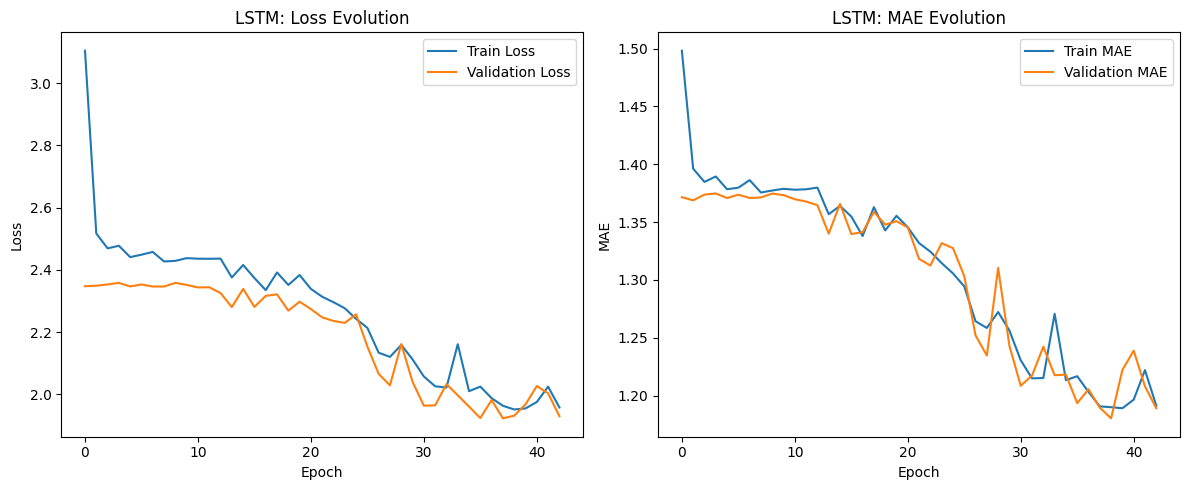

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error, r2_score


df = pd.read_csv('merged_data.csv')
y = df['stars']
drop_cols = ['address', 'business_id', 'name', 'postal_code', 'review_id',
             'user_id', 'date', 'date_dt', 'date_only', 'text']
X = df.drop(drop_cols + ['stars'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_nn = X_train_processed.astype('float32')
X_test_nn = X_test_processed.astype('float32')
y_train_nn = y_train.values.astype('float32')
y_test_nn = y_test.values.astype('float32')

sequence_length = X_train_nn.shape[1]
X_train_cnn = X_train_nn.reshape(-1, sequence_length, 1)
X_test_cnn = X_test_nn.reshape(-1, sequence_length, 1)

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

lstm_model = build_lstm_model((sequence_length, 1))
history_lstm = lstm_model.fit(
    X_train_cnn, y_train_nn,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


lstm_pred = lstm_model.predict(X_test_cnn).flatten()
lstm_mse = mean_squared_error(y_test_nn, lstm_pred)
lstm_r2 = r2_score(y_test_nn, lstm_pred)
print(f"LSTM - MSE: {lstm_mse:.4f}, R2: {lstm_r2:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM: Loss Evolution')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['mae'], label='Train MAE')
plt.plot(history_lstm.history['val_mae'], label='Validation MAE')
plt.title('LSTM: MAE Evolution')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()
